In [12]:
import numpy as np
from choclo.prism import magnetic_field
import math
import numba

def components_vector(amp, incl, decl):
    x = amp * math.sin(math.radians(incl)) * math.cos(math.radians(decl))
    y = amp * math.sin(math.radians(incl)) * math.sin(math.radians(decl))
    z = amp * math.cos(math.radians(incl))
    return (x, y, z)


dim = np.asarray([1024,1024,512]) / 2
h = [100.0, 100.0, 100.0]
Dx = h[0]
Dy = h[1]

x = Dx*np.arange(-dim[0]+1,dim[0]+1)
y = Dy*np.arange(-dim[1]+1,dim[1]+1)

X,Y = np.meshgrid(x,y)

x = X.flatten()
y = Y.flatten()

# Define the boundaries of the prism as a 1d-array
prism = np.array([-10000.0, 10000.0, -10000.0, 10000.0, -40000.0, -10000.0])

magnetization = components_vector(0.1, 0.0, 0.0)
# magnetization = (0.1, 0.1, 0.1)

@numba.jit(nopython=True)
def mag_jit(x, y, prism, magnetization):

    results = []

    for ii in range(x.shape[0]):

        # Define a single computation point
        easting, northing, upward = x[ii], y[ii], 10.0

        # Compute the upward component of the grav. acceleration
        mag = magnetic_field(easting, northing, upward, prism, magnetization)
        results.append(np.sum(np.asarray(mag)**2)**0.5)

    return results

results = mag_jit(x, y, prism, magnetization)


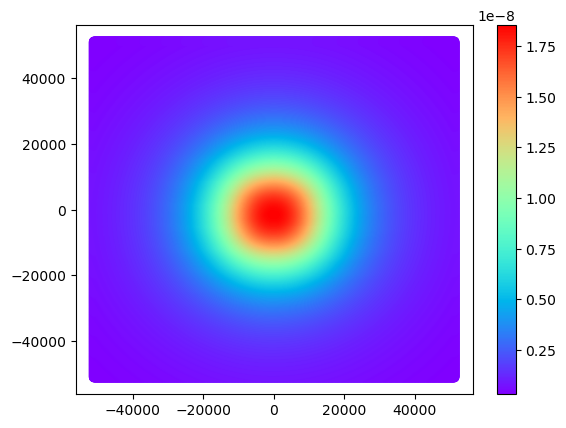

In [13]:
# np.sum(np.asarray(g_u)**2)**0.5
import matplotlib.pyplot as plt
plt.scatter(x, y, c=results, cmap='rainbow')
plt.colorbar()


In [25]:
import os, sys
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch
# import numpy as np
import scipy as sp
from scipy.constants import mu_0
import scipy.sparse as sparse
# import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torch.optim as optim
from scipy.sparse.linalg import spsolve

import torchvision
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from time import time

class magnetics(nn.Module):
    
    def __init__(self, dim, h, dirs, device='cpu'):
        super(magnetics, self).__init__()
        self.dim    = dim   # Mesh size [nx, ny, nz]
        self.h      = h     # cell size [Dx, Dy, Dz]
        self.dirs   = dirs  # magnetic field directions [A, I, A0, I0]
        self.device = device 
        dV = torch.prod(self.h)
        mu_0 = 4*np.pi*1e-7
        zeta = mu_0 / (4 * np.pi)
        self.mudV = zeta*dV

    def fft_kernel(self, P, center):
            # use centers and the response and shift the data for FD operations
            S = torch.fft.fftshift(torch.roll(P, shifts=center, dims=[0,1]))
            # take the fft
            S = torch.fft.fft2(S)
            # shift again to swap quadrants
            S = torch.fft.fftshift(S)
            return S

    def forward(self, M):
        """
            Solve the forward problem using FFT
            :param M: model
            :type M: Tensor
        """
        
        # define the constants
        Dz = self.h[2]
        Z  = Dz/2
        
        Data = 0 
        
        # loop through each layer of the model
        for i in range(M.shape[-1]):
            
            # pull out the layer from the model
            I = M[:,:,i]

            # calculate the response the layer of the model
            P, center, Rf = self.psfLayer(Z)
            
            # use centers and the response and shift the data for FD operations
            S = self.fft_kernel(P, center)

            # do the same to model tensor
            I_fft = torch.fft.fftshift(I)
            I_fft = torch.fft.fft2(I_fft)
            I_fft = torch.fft.fftshift(I_fft)

            # perform the FD operations
            B = S * I_fft
            B = torch.fft.fftshift(B)

            # convert back to spatial domain
            B = torch.real(torch.fft.ifft2(B))

            # add the data response from the layer
            Data = Data+B
            Z = Z + Dz
        
        return self.mudV * Data
    
    def adjoint_a(self, I):
        # Adjoint for testing
        a = torch.ones(self.dim[0], self.dim[1], self.dim[2], requires_grad=True, device=self.device)
        d = self.forward(a)
        b = torch.sum(d*I)
        out = grad(b,a)[0]
        return out

    def adjoint(self, I):
        
        Dz = self.h[2]
        
        Z = Dz/2
        M  = torch.zeros(self.dim[0], self.dim[1], self.dim[2], device=self.device)
        
        for i in range(M.shape[-1]):

            # calculate the response the layer of the model
            P, center, Rf = self.psfLayer(Z)
            # use centers and the response and shift the data for FD operations
            S = self.fft_kernel(P, center)

            # do the same to model tensor
            I_fft = torch.fft.fft2(I)
            I_fft = torch.fft.fftshift(I_fft)

            # perform the FD operations
            B = torch.adjoint(S) * I_fft

            # convert back to spatial domain
            B = torch.fft.fftshift(B)
            B = torch.real(torch.fft.ifft2(B))
            B = torch.fft.fftshift(B)
            
            # add the data response from the layer
            M[:,:,i] = B
            Z = Z + Dz
        
        return self.mudV*M
    
    def psfLayer(self, Z):
         #I is the magnetization dip angle 
         # A is the magnetization deflection angle
         # I0 is the geomagnetic dip angle
         # A0 is the geomagnetic deflection angle

        dim2 = torch.div(self.dim,2,rounding_mode='floor')
        Dx = self.h[0]
        Dy = self.h[1]
        I  = self.dirs[0]
        A  = self.dirs[1]
        I0 = self.dirs[2]
        A0 = self.dirs[3]
        
        x = Dx*torch.arange(-dim2[0]+1,dim2[0]+1, device=self.device)
        y = Dy*torch.arange(-dim2[1]+1,dim2[1]+1, device=self.device)
        X,Y = torch.meshgrid(x,y)

        # Get center ready for fftshift.
        center = [1 - int(dim2[0]), 1 - int(dim2[1])]

        Rf = torch.sqrt(X**2 + Y**2 + Z**2)**5
        PSFx = (2*X**2 - Y**2 - Z**2)/Rf*torch.cos(I)*torch.sin(A) + \
               3*X*Y/Rf*torch.cos(I)*torch.cos(A) + \
               3*X*Z/Rf*torch.sin(I)

        PSFy = 3*X*Y/Rf*torch.cos(I)*torch.sin(A) + \
               (2*Y**2 - X**2 - Z**2)/Rf*torch.cos(I)*torch.cos(A) + \
               3*Y*Z/Rf*torch.sin(I)

        PSFz = 3*X*Z/Rf*torch.cos(I)*torch.sin(A) + \
               3*Z*Y/Rf*torch.cos(I)*torch.cos(A) +\
               (2*Z**2 - X**2 - Y**2)/Rf*torch.sin(I)

        PSF = PSFx*torch.cos(I0)*torch.cos(A0) + \
              PSFy*torch.cos(I0)*torch.sin(A0) + \
              PSFz*torch.sin(I0) 
        
        return PSF, center, Rf

if True:

    #time_s = time()
    
    # Adjoint test
    adjoint_test = False
    
    dim = torch.tensor([1024,1024,512])
    h = torch.tensor([100.0, 100.0, 100.0])
    dirs = torch.tensor([0, np.pi/2, 0, 0])
    forMod = magnetics(dim, h, dirs)

    # set the magnetization model
    M = torch.ones(dim[0], dim[1], dim[2], device='cpu') * 0.0
    # M[600:800, 600:800, 100:400] = 0.1
    M[412:612, 412:612, 100:400] = 0.1

    D = forMod(M)

    # #print(f'Done: {time() - time_s} seconds')

    # plt.imshow(D.view(1024, 1024).cpu().detach().numpy(), cmap='rainbow')
    # # plt.imshow(M[:, 512, :].view(1024, 512).T.cpu().detach().numpy(), cmap='rainbow')
    # plt.title('Centerd Block I=90 D=90 degrees')
    # plt.colorbar()
    # plt.show()

    # Adjoint test
    if adjoint_test:
        dim = torch.tensor([1024,1024,64])
        h = torch.tensor([100.0, 100.0, 100.0])
        dirs = torch.tensor([np.pi/4, np.pi/4, np.pi/4, np.pi/4])
        forMod = magnetics(dim, h, dirs)

        M = torch.rand(dim[0], dim[1], dim[2], device='cpu')
        D = forMod(M)
        Q = torch.rand_like(D)
        W = forMod.adjoint(Q)
        Wa = forMod.adjoint_a(Q)

        print('Adjoint test 1', torch.sum(M*W).item(), torch.sum(D*Q).item())
        print('Adjoint test 2', (W-Wa).norm()/Wa.norm())
        

    print('Done')


Done


torch.Size([1024, 1024]) (1024, 1024)


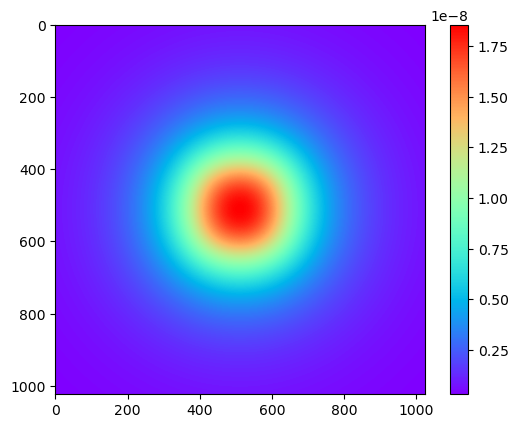

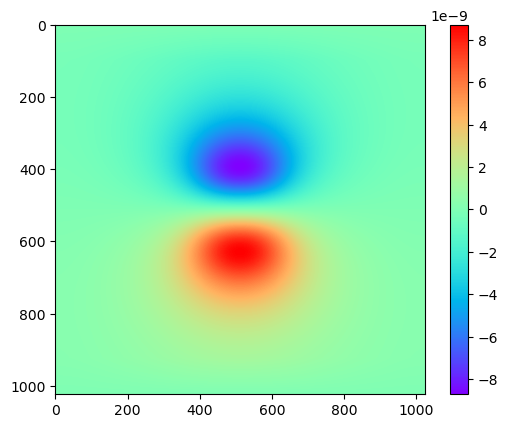

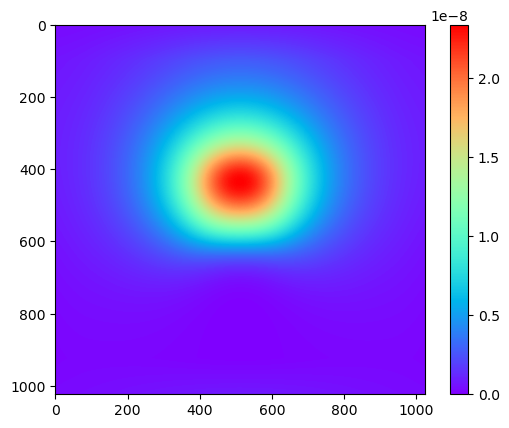

In [26]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
choclo_mag = np.reshape(results, (1024, 1024))
print(D.shape, choclo_mag.shape)
plt.imshow(choclo_mag, cmap='rainbow')
plt.colorbar()
plt.show()

plt.imshow(D.view(1024, 1024).cpu().detach().numpy(), cmap='rainbow')
plt.colorbar()
plt.show()

plt.imshow(choclo_mag - D.view(1024, 1024).cpu().detach().numpy(), cmap='rainbow')
plt.colorbar()
plt.show()

In [142]:
import pynoddy
import sys, os
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
sys.path.append(repo_path)
import pynoddy.history

In [148]:
# Combined: model generation and output vis to test:
history = r"C:\Users\johnk\Documents\projects\ubc\simple_model.his"
output_name = r"C:\Users\johnk\Documents\projects\ubc\simple_out"

import importlib
importlib.reload(pynoddy.history)
importlib.reload(pynoddy.events)

# create pynoddy object
nm = pynoddy.history.NoddyHistory()
# add stratigraphy
strati_options = {'num_layers' : 8,
                  'layer_names' : ['layer 1', 'layer 2', 'layer 3', 
                                   'layer 4', 'layer 5', 'layer 6', 
                                   'layer 7', 'layer 8'],
                  'layer_thickness' : [1500, 500, 500, 500, 500, 500, 500, 500]}
nm.add_event('stratigraphy', strati_options )

nm.write_history(history)

# Compute the model
importlib.reload(pynoddy)
pynoddy.compute_model(history, output_name) 

# Plot output
import pynoddy.output
importlib.reload(pynoddy.output)
nout = pynoddy.output.NoddyOutput(output_name)
nout.plot_section('y', layer_labels = strati_options['layer_names'][::-1], 
                  colorbar = True, title="",
                  savefig = False, fig_filename = "ex01_strati.eps")

OSError: 

## Simpeg Geoana

In [2]:
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, epsilon_0

from geoana import utils, spatial
from geoana.em import static

In [5]:
mu = mu_0  # permeability of free space (this is the default)
location = np.r_[0., 0., -25000]  # location of the dipole or pole

# dipole parameters
moment = 0.1 * 
# inclination and declination (e.g. Vancouver)
inclination, declination = 90., 0.

def id_to_cartesian(inclination, declination):
    ux = np.cos(inclination/180.*np.pi)*np.sin(declination/180.*np.pi)
    uy = np.cos(inclination/180.*np.pi)*np.cos(declination/180.*np.pi)
    uz = -np.sin(inclination/180.*np.pi)
    return np.r_[ux, uy, uz]

orientation = id_to_cartesian(inclination, declination)

dipole = static.MagneticDipoleWholeSpace(
    location=location,
    orientation=orientation,
    moment=moment
)

pole = static.MagneticPoleWholeSpace(
    location=location,
    orientation=orientation,
    moment=moment
)

x = Dx*np.arange(-dim[0]+1,dim[0]+1)
y = Dy*np.arange(-dim[0]+1,dim[0]+1)
xyz = utils.ndgrid([x, y, np.r_[10.]])

# evaluate the magnetic field
b_vec_dipole = dipole.magnetic_flux_density(xyz)
b_vec_pole = pole.magnetic_flux_density(xyz)
b_total_dipole = dipole.dot_orientation(b_vec_dipole)
b_total_pole = pole.dot_orientation(b_vec_pole)

def plot_amplitude(ax, v):
    plt.colorbar(
        ax.pcolormesh(
            x, y, v.reshape(len(x), len(y), order='F')
        ), ax=ax
    )
    ax.axis('square')
    ax.set_xlabel('y (east,  m)')
    ax.set_ylabel('x (north,  m)')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# plot dipole vector potential
plot_amplitude(ax[0], b_total_dipole)

# plot loop vector potential
plot_amplitude(ax[1], b_total_pole)


# set the titles
ax[0].set_title("Total field: dipole")
ax[1].set_title("Total field: pole")

# format so text doesn't overlap
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [8]:
import torch_mesh as pmesh
import torch
from regularizationL2 import L2_regularization
from torch_maps import IdentityMap
# import scipy.sparse as sp
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import matplotlib.pyplot as plt


def cell_faces(n1, n2, n3, h1, h2, h3):

    # create identity matrices for each dir.
    n1_I = torch.sparse.spdiags(torch.ones([n1 + 1, 1]).T, torch.tensor([0]), (n1 + 1, n1 + 1)).coalesce()
    n2_I = torch.sparse.spdiags(torch.ones([n2 + 1, 1]).T, torch.tensor([0]), (n2 + 1, n2 + 1)).coalesce()
    n3_I = torch.sparse.spdiags(torch.ones([n3 + 1, 1]).T, torch.tensor([0]), (n3 + 1, n3 + 1)).coalesce()
    h1_d = torch.sparse.spdiags(h1, torch.tensor([0]), (n1, n1)).coalesce()
    h2_d = torch.sparse.spdiags(h2, torch.tensor([0]), (n2, n2)).coalesce()
    h3_d = torch.sparse.spdiags(h3, torch.tensor([0]), (n3, n3)).coalesce()

    # do x
    Fx = mesh.kronecker_product_sparse(h3_d, mesh.kronecker_product_sparse(h2_d, n1_I)).values()

    # do y
    Fy = mesh.kronecker_product_sparse(h3_d, mesh.kronecker_product_sparse(n2_I, h1_d)).values()

    # do z
    Fz = mesh.kronecker_product_sparse(n3_I, mesh.kronecker_product_sparse(h2_d, h1_d)).values()

    dims = Fx.shape[0] + Fy.shape[0] + Fz.shape[0]

    return torch.sparse.spdiags(torch.hstack([Fx, Fy, Fz]), torch.tensor([0]), (dims, dims)).coalesce()


def cell_lengths(n1, n2, n3, h1, h2, h3):

    # create identity matrices for each dir.
    n1_I = torch.sparse.spdiags(torch.ones([n1 + 1, 1]).T, torch.tensor([0]), (n1 + 1, n1 + 1)).coalesce()
    n2_I = torch.sparse.spdiags(torch.ones([n2 + 1, 1]).T, torch.tensor([0]), (n2 + 1, n2 + 1)).coalesce()
    n3_I = torch.sparse.spdiags(torch.ones([n3 + 1, 1]).T, torch.tensor([0]), (n3 + 1, n3 + 1)).coalesce()
    h1_d = torch.sparse.spdiags(h1, torch.tensor([0]), (n1, n1)).coalesce()
    h2_d = torch.sparse.spdiags(h2, torch.tensor([0]), (n2, n2)).coalesce()
    h3_d = torch.sparse.spdiags(h3, torch.tensor([0]), (n3, n3)).coalesce()

    # do x
    Lx = mesh.kronecker_product_sparse(n3_I, mesh.kronecker_product_sparse(n2_I, h1_d)).values()

    # do y
    Ly = mesh.kronecker_product_sparse(n3_I, mesh.kronecker_product_sparse(h2_d, n1_I)).values()

    # do z
    Lz = mesh.kronecker_product_sparse(h3_d, mesh.kronecker_product_sparse(n2_I, n1_I)).values()
    print(Lx.shape, Ly.shape, Lz.shape)

    dims = Lx.shape[0] + Ly.shape[0] + Lz.shape[0]
    # L = sp.diags(sp.hstack([
    # sp.kron(sp.eye(n3 + 1), sp.kron(sp.eye(n2 + 1), sp.diags(h1))).diagonal(),
    # sp.kron(sp.eye(n3 + 1), sp.kron(sp.diags(h2), sp.eye(n1 + 1))).diagonal(),
    # sp.kron(sp.diags(h3), sp.kron(sp.eye(n2 + 1), sp.eye(n1 + 1))).diagonal()]).toarray(), [0]
    # )

    return torch.sparse.spdiags(1 / torch.hstack([Lx, Ly, Lz]), torch.tensor([0]), (dims, dims)).coalesce()


def nodal_to_cellcenter_matrix(n1, n2, n3):

    def av(n):
            return torch.sparse.spdiags((torch.ones(n + 1, 1) * torch.from_numpy(np.asarray([0.5, 0.5]))).T,
                                         torch.tensor([0, 1]), (n, n + 1)).coalesce()

    return mesh.kronecker_product_sparse(av(n3), mesh.kronecker_product_sparse(av(n2), av(n1)))


n1=10
n2=10
n3=5
h1=10 * torch.ones(n1)
h2=10 * torch.ones(n2)
h3=10 * torch.ones(n3)

# F = cell_faces(n1, n2, n3, h1, h2, h3)
# Linv = cell_lengths(n1, n2, n3, h1, h2, h3)
# print(cell_gardient_x(n1, n2, n3, h1, h2, h3))
# print(average_cell_to_face(n1, n2, n3).shape)

jmesh = pmesh.torch_mesh(h1, h2, h3)

ref_mod = torch.ones(jmesh.number_of_cells) * 0.001

model = ref_mod
model[54:86] = 0.1

ref_mod = torch.ones(jmesh.number_of_cells) * 0.001
mapping = IdentityMap(mesh=jmesh, nP=jmesh.number_of_cells)
# W = torch.sparse.spdiags(torch.ones(jmesh.number_of_cells, 1).T, torch.tensor([0]), (jmesh.number_of_cells, 550)).coalesce()
reg = L2_regularization(jmesh, mapping=mapping, reference_model=ref_mod)
# print(jmesh.shape_faces_x())
# print(jmesh.average_cell_to_face().shape, face_areas.shape, jmesh.cell_volumes().shape, V.shape)
# fa_v = face_areas / V
# print((reg.Pafx().T @ reg.mesh.cell_gradient_x() @ reg.Pac()).shape)

# print((W @ reg.cell_gradient_x() @ reg.delta_m(model)).shape)
# print(torch.prod(torch.tensor(jmesh.shape_faces_x())))
print(reg(model))
print(reg.deriv(model).shape)

# diag_d = (torch.ones([n, 1]) * torch.from_numpy(np.asarray([-1, 1])))

# # D = sp.spdiags((np.ones((n + 1, 1)) * [-1, 1]).T, [-1, 0]

# # diag_d[0, 0] = 0
# # diag_d[-1, -1] = 0

# D_ = torch.sparse.spdiags(diag_d.T,
#                         torch.tensor([-1, 0]),
#                         (n + 1, n)).coalesce()

# stencil_values = D_.values()
# stencil_indices = D_.indices()
# stencil_values[0] = 0
# stencil_values[-1] = 0
# D = torch.sparse_coo_tensor(torch.vstack([stencil_indices[0, :], stencil_indices[1, :]]), stencil_values, (n+1, n)).coalesce()
# print(D_.indices()[:, 0])
# print(D_.values())
# plt.spy(jmesh.cell_gardient_x().to_dense())
# plt.grid(True)
# plt.show()



tensor(0.1016)
torch.Size([500])


In [83]:
import scipy.sparse as sp
import numpy as np

def getMeshGeometry(h1, h2, h3):

    n1 = h1.size
    n2 = h2.size
    n3 = h3.size

    V = sp.kron(sp.diags(h3), sp.kron(sp.diags(h2), sp.diags(h1)))

    F = sp.diags(sp.hstack([sp.kron(sp.diags(h3), sp.kron(sp.diags(h2), sp.eye(n1+1))).diagonal(),
            sp.kron(sp.diags(h3), sp.kron(sp.eye(n2 + 1), sp.diags(h1))).diagonal(),
            sp.kron(sp.eye(n3 + 1), sp.kron(sp.diags(h2),sp.diags(h1))).diagonal()]).toarray(), [0])

    L = sp.diags(sp.hstack([
        sp.kron(sp.eye(n3 + 1), sp.kron(sp.eye(n2 + 1), sp.diags(h1))).diagonal(),
        sp.kron(sp.eye(n3 + 1), sp.kron(sp.diags(h2), sp.eye(n1 + 1))).diagonal(),
        sp.kron(sp.diags(h3), sp.kron(sp.eye(n2 + 1), sp.eye(n1 + 1))).diagonal()]).toarray(), [0]
        )

    return V, F, L


def getNodalGradientMatrix(n1, n2, n3):
    """

        calculates the gradient matrix

    """
    
    def ddx(n):
        return sp.spdiags((np.ones([n+1,1])*np.array([-1,1])).T,[0,1],n,n+1)
    
    G1 = sp.kron(sp.eye(n3+1), sp.kron(sp.eye(n2+1),ddx(n1)))
    G2 = sp.kron(sp.eye(n3+1), sp.kron(ddx(n2),sp.eye(n1+1)))
    G3 = sp.kron(ddx(n3),sp.kron(sp.eye(n2+1),sp.eye(n1+1)))
    # grad on the nodes
    print(G1.shape, G2.shape, G3.shape)
    Grad = sp.vstack([G1, G2, G3])

    return Grad


n1=10
n2=10
n3=5
h1=10 * np.ones(n1)
h2=10 * np.ones(n2)
h3=10 * np.ones(n3)


def av(n):
    return sp.spdiags((np.ones([n+1,1])*np.array([0.5,0.5])).T,[0,1],n,n+1)

A1 = sp.kron(sp.eye(n3),sp.kron(sp.eye(n2),av(n1)))
A2 = sp.kron(sp.eye(n3),sp.kron(av(n2),sp.eye(n1)))
A3 = sp.kron(av(n3),sp.kron(sp.eye(n2),sp.eye(n1)))
# average from faces to cell-centers
Afc = sp.hstack([A1, A2, A3])
V, F, L = getMeshGeometry(h1, h2, h3)
grad = getNodalGradientMatrix(n1, n2, n3)
print(V.shape, grad.shape, A1.shape, Afc.shape, L.shape, F.shape)
# plt.spy((grad).todense())
# plt.grid(True)
# plt.show()



(660, 726) (660, 726) (605, 726)
(500, 500) (1925, 726) (500, 550) (500, 1700) (1925, 1925) (1700, 1700)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

import discretize
from SimPEG import (
    maps,
    optimization,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    Report,
)

# ln conductivity
ln_sigback = -5.0
ln_sigc = -3.0
ln_sigr = -6.0

# ---------------------------------------------------------------------------------

# computational mesh

#

# Cell sizes
csx, csy, csz = 10.0, 10.0, 10.0
# Number of core cells in each direction
ncx, ncy, ncz = 10, 10, 5
# Number of padding cells to add in each direction
npad = 7
# Vectors of cell lengths in each direction with padding
hx = [(csx, ncx)]
hy = [(csy, ncy)]
hz = [(csz, ncz)]
# Create mesh and center it
mesh = discretize.TensorMesh([hx, hy, hz], x0="CCN")

# Define model
# Background
mtrue = ln_sigback * np.ones(mesh.nC)

print("the mesh has {} cells".format(mesh.nC))

# -------------------------------------------------------------------------------------

# setup a regularization

#

regT = regularization.Tikhonov(
    mesh, alpha_s=1e-6, alpha_x=1.0, alpha_y=1.0, alpha_z=1.0
)



the mesh has 500 cells


In [1]:
# import scipy.sparse as sp
# n = ncx
# import SimPEG
# print(SimPEG.__version__)
# print(regT.objfcts[3].cell_gradient @ regT.objfcts[3].mapping.deriv(model.detach().numpy()))
# print(regT._delta_m(model.detach().numpy()).shape)
# print("\n\n")
# print(regT.deriv(model.detach().numpy()).shape)

# nx = [0, 0, 0]
# nx[0] = mesh.shape_faces_x
# nx[1] = mesh.shape_faces_y
# nx[2] = mesh.shape_faces_z
# dim = 2
# start = np.sum(nn[: dim + 1])
# end = np.sum(nn[: dim + 2])
# print(nn, np.prod(nx[0]))
# print(mesh.shape_faces_x, np.prod(mesh.shape_faces_x), L.shape, mesh._parse_location_type("F"), nn, nx, start, end, mesh.shape_cells)
# print(mesh.face_areas.shape, V.shape, mesh.aveCC2F.shape)
# print(mesh.aveFx2CC.shape)
# print(mesh.cell_gradient_x.shape)
# print(mesh.face_areas.shape)

# print(sp.spdiags(
#         (0.5 * np.ones((n, 1)) * [1, 1]).T, [-1, 0], n + 1, n, format="csr"
#     ).shape)

# print(sp.csr_matrix(([0.5, 0.5], ([0, n], [0, n - 1])), shape=(n + 1, n)))
# # mesh.plot_grid().plot_mesh()
# print(np.min(np.abs(regT.W.data)), np.max(regT.W.data))

# plt.spy(regT.W.todense())
# plt.grid(True)
# plt.show()

# t = (torch.ones([n + 1, 1]) * torch.from_numpy(np.asarray([-1, 1])))
# t[0, 0] = 0.0
# t[-1, -1] = 0.0
# print(t)
# D1 = torch.sparse.spdiags((torch.ones([n, 1]) * torch.from_numpy(np.asarray([-1, 1]))).T,
#                                 torch.tensor([-1, 0]),
#                                 (n + 1, n)).coalesce()
# print(D1.shape)
# print(D1)
# plt.spy(D1.to_dense())
# plt.grid(True)
# plt.show()

# print(10**0.5)

import os, sys
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torch.optim as optim
from scipy.sparse.linalg import spsolve

import magneticsForward as MF
from regularizationL2 import L2_regularization
from torch_maps import IdentityMap
import torch_mesh as tmesh
import solvers

dim = torch.tensor([128,128,64])
h = torch.tensor([100.0, 100.0, 100.0])
dirs = torch.tensor([np.pi/2, np.pi/2, np.pi/2, np.pi/2])
forMod = MF.magnetics(dim, h, dirs, device='cpu')
#forMod = MF.testFM(dim, h, dirs, device='cpu')

n1 = 128
n2 = 128
n3 = 64
h1 = 100 * torch.ones(n1)
h2 = 100 * torch.ones(n2)
h3 = 100 * torch.ones(n3)

jmesh = tmesh.torch_mesh(h1, h2, h3)
mapping = IdentityMap(mesh=jmesh, nP=jmesh.number_of_cells)

# set the magnetization model
M = torch.ones(dim[0], dim[1], dim[2], device='cpu') * 0.0
M[40:60, 40:60, 10:40] = 0.1

D = forMod(M)*1e8
reg = L2_regularization(jmesh, mapping=mapping, reference_model=(M*0).flatten())
print((M*0).flatten().shape, D.flatten().shape)
sol = solvers.CGLS(forMod, reg=reg, CGLSit=100, eps = 1e-5, device='cpu')

x, r = sol(D, M*0)

# # Ax = b   A Ez = b 
# print('Done: ', x[:, :, 32].shape)
# plt.imshow(M[:, :, 32].T.detach().numpy())
# plt.show()


c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1048576]) torch.Size([16384])
dmis: 576.503173828125 m_mis: 0.0
alpha, p: tensor([7.6289e-05]), tensor([[[-2.1393e+00, -5.0698e-02, -4.8448e-02,  ..., -2.5467e-03,
          -2.1537e-03, -1.7809e-03],
         [-2.1808e+00, -5.3491e-02, -5.1117e-02,  ..., -2.2408e-03,
          -1.8502e-03, -1.4804e-03],
         [-2.2225e+00, -5.6309e-02, -5.3818e-02,  ..., -1.9213e-03,
          -1.5336e-03, -1.1669e-03],
         ...,
         [-2.0161e+00, -4.2285e-02, -4.0553e-02,  ..., -3.3740e-03,
          -2.9754e-03, -2.5959e-03],
         [-2.0570e+00, -4.5120e-02, -4.3172e-02,  ..., -3.1142e-03,
          -2.7172e-03, -2.3397e-03],
         [-2.0981e+00, -4.7915e-02, -4.5802e-02,  ..., -2.8381e-03,
          -2.4430e-03, -2.0677e-03]],

        [[-2.1808e+00, -5.3491e-02, -5.1117e-02,  ..., -2.2408e-03,
          -1.8502e-03, -1.4804e-03],
         [-2.2234e+00, -5.6424e-02, -5.3919e-02,  ..., -1.9203e-03,
          -1.5328e-03, -1.1662e-03],
         [-2.2662e+00, -5.9388e-02, 

KeyboardInterrupt: 

$$r(m) = \frac{1}{2} \| \mathbf{W} \mathbf{f(m)} \|_2^2$$

$$R(m) = \frac{1}{2}\mathbf{(m-m_\text{ref})^\top W^\top
                   W(m-m_\text{ref})}$$

$$R(m) = \mathbf{W^\top W}$$

$$
r(m) = \frac{1}{2}(\mathbf{m} - \mathbf{m_ref})^\top \mathbf{V}^T
            \mathbf{W}^T
        \mathbf{W} \mathbf{V} (\mathbf{m} - \mathbf{m_{ref}})
$$

$$
R(m) = \frac{1}{2}\mathbf{(m-m_\text{ref})^\top W^\top
                   W(m-m_\text{ref})}
$$

$$
R(m) = \mathbf{W^\top W (m-m_\text{ref})}
$$

$$
r(m) = \frac{1}{2} \| \mathbf{W} \mathbf{f(m)} \|_2^2
$$

$$
\begin{bmatrix}
        1/2 & 1/2 & & & \\
        & 1/2 & 1/2 & & \\
        & & \ddots & \ddots & \\
        & & & 1/2 & 1/2
        \end{bmatrix}
$$